In [22]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df_train = pd.read_csv('nlp-getting-started/train.csv')
df_test = pd.read_csv('nlp-getting-started/test.csv')

In [15]:
df_train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


0    4342
1    3271
Name: target, dtype: int64


C:\Users\abhil\anaconda3\envs\KerasPython37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


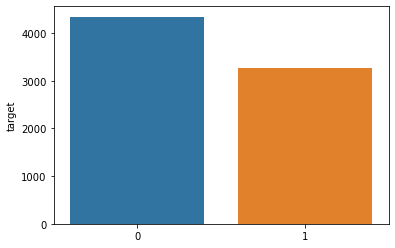

In [11]:
x = df_train['target'].value_counts()
print(x)
sns.barplot(x.index,x)

In [14]:
# Missing values

df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [20]:
# Number of words in a tweet:

df_train['word_count'] = df_train['text'].apply(lambda x : len(str(x).split()))

# disaster tweets
print(df_train[df_train['target'] == 1]['word_count'].mean())

#Non disaster tweets
print(df_train[df_train['target'] == 0]['word_count'].mean())

15.167532864567411
14.704744357438969


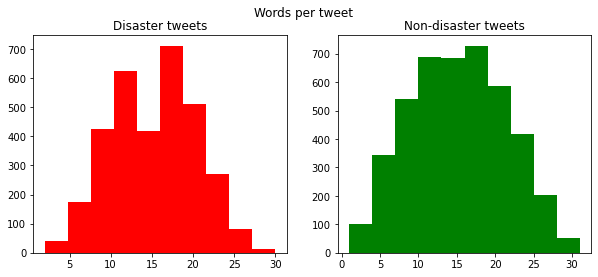

In [23]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['target']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Disaster tweets')
train_words=df_train[df_train['target']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Words per tweet')
plt.show()

In [24]:
# char count
df_train['char_count'] = df_train['text'].apply(lambda x : len(str(x)))

# disaster tweets
print(df_train[df_train['target'] == 1]['char_count'].mean())

#Non disaster tweets
print(df_train[df_train['target'] == 0]['char_count'].mean())

108.11342097217977
95.70681713496084


### Text preprocessing 